### project3_3_ridge_lasso.ipynb,

wherein I attempt some more to get better results out of my logistic regression model:

In [76]:
# import the basics, + plotting, + crossval searching:

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer



#### First I need to pull in the various files I saved at the end of the previous notebook:

Get the data, and clean it just like before:

In [77]:
df = pd.read_csv('./data/redditcomments.csv')
df.drop(columns='Unnamed: 0',inplace=True)
df.dropna(inplace=True)
df['char_length'] = [len(comment) for comment in list(df['comment'])]
df = df[(df['char_length']>=10) & (df['char_length']<1000)]
df.head()

,comment,date,types,char_length
0,I think it's the end of the first episode rath...,1615999558,fantasy,76
1,I think you mean the prologue of the Wheel of ...,1615999475,fantasy,87
2,"Not properly ""Fantasy"", but ""Horus Rising"" ope...",1615999395,fantasy,218
3,Love that trilogy. Bit slow to get started (af...,1615999383,fantasy,85
4,&gt;At this point I think Sanderson being the ...,1615999332,fantasy,566


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18746 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   comment      18746 non-null  object
 1   date         18746 non-null  int64 
 2   types        18746 non-null  object
 3   char_length  18746 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 732.3+ KB


In [ ]:
comments = list(df['comment'])
df['flagged'] = [1 if ('removed' in comment.split(' ')) else 0 for comment in comments]
df = df[df['flagged']==0]

Get my stop words files, the predictions dataframe, the probabilities, and the scores (so far):

In [79]:
stops_df = pd.read_csv('./data/stopwords.csv')
stops = list(stops_df['0'])
stops

['thick',
 'beyond',
 'six',
 'hereafter',
 'both',
 'her',
 'am',
 'forty',
 'very',
 'its',
 'above',
 'ours',
 'who',
 'someone',
 'might',
 'whenever',
 'per',
 'un',
 'may',
 'cannot',
 'formerly',
 'before',
 'up',
 'of',
 'amongst',
 'couldnt',
 'more',
 'four',
 'it',
 'thereupon',
 'there',
 'again',
 'him',
 'beside',
 'they',
 'less',
 'us',
 'hasnt',
 'in',
 'while',
 'one',
 'seeming',
 'had',
 'several',
 'thereafter',
 'since',
 'ten',
 'for',
 'too',
 'been',
 'de',
 'etc',
 'herself',
 'wherein',
 'herein',
 'during',
 'such',
 'noone',
 'yours',
 'serious',
 'whether',
 'enough',
 'whoever',
 'cant',
 'must',
 'eg',
 'otherwise',
 'itself',
 'get',
 'them',
 'why',
 'few',
 'nobody',
 'rather',
 'between',
 'ourselves',
 'fill',
 'below',
 'are',
 'indeed',
 'mine',
 'still',
 'perhaps',
 'thence',
 'most',
 'others',
 'no',
 'go',
 'then',
 'inc',
 'have',
 'hers',
 'twenty',
 'this',
 'full',
 'me',
 'either',
 'side',
 'onto',
 'five',
 'latterly',
 'con',
 'except

In [80]:
predictions = pd.read_csv('./data/predictions.csv')
predictions.drop(columns = 'Unnamed: 0', inplace=True)
predictions.head()

,types,Simple NB,Simple LR,LR 5000 features
0,fantasy,fantasy,fantasy,fantasy
1,fantasy,fantasy,fantasy,fantasy
2,scifi,scifi,scifi,scifi
3,scifi,scifi,scifi,scifi
4,scifi,scifi,scifi,scifi


In [81]:
predicted_probabilities = pd.read_csv('./data/predicted_probabilities.csv')
predicted_probabilities.drop(columns = 'Unnamed: 0', inplace=True)
predicted_probabilities.head()

,types,prediction,err type,err label,probability
0,0,0,0,"fantasy, correct",2.081928e-01
1,0,0,0,"fantasy, correct",2.242084e-08
2,1,1,3,"scifi, correct",9.309696e-01
3,1,1,3,"scifi, correct",9.962833e-01
4,1,1,3,"scifi, correct",7.649797e-01


In [87]:
scores = pd.read_csv('./data/scores.csv')


Set X and y, do the train test split, and count vectorize:

In [86]:
X = df['comment']
y = df['types']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify=y)
cv = CountVectorizer(stop_words=stops)
cv.fit(X_train,y_train)
Xvec_train = cv.transform(X_train)
Xvec_test  = cv.transform(X_test)



Regularize using LASSO. It takes a long time, so I'm just trying one C value at a time for LASSO:

In [41]:
lr_lasso = LogisticRegressionCV(penalty= 'l1', solver= 'saga', Cs=[1], max_iter=1000,verbose=2)
lr_lasso.fit(Xvec_train,y_train)
lasso_train = lr_lasso.score(Xvec_train,y_train)
lasso_test = lr_lasso.score(Xvec_test,y_test)
print(f'Train: {lasso_train}, Test: {lasso_test}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 142 seconds


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


max_iter reached after 135 seconds


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 133 seconds


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 127 seconds


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 134 seconds


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.2min finished


max_iter reached after 172 seconds
Train: 0.8928673527730131, Test: 0.7892367066895368


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [50]:
scores

,model,train,test
0,Baseline,0.501809,0.501909
1,NBayesian,0.829448,0.779184
2,LogReg,0.940715,0.814949
3,LogReg 5000,0.894628,0.801085


So the LASSO best score (C=1) is lower, test and train, than my simple model. It's less overfit, but the score is lower.

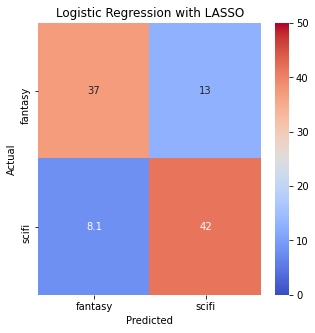

In [43]:
# plot the confusion matrix just like before:

subreddits = ['fantasy', 'scifi']
fig = plt.figure(figsize=(5,5));
ax = fig.add_subplot(111);
preds_lasso = lr_lasso.predict(Xvec_test)
cm = confusion_matrix(y_test, preds_lasso)
cm = cm*100/sum(sum(cm));
sns.heatmap(cm,ax=ax,annot=True, vmin = 0, vmax = 50, cmap='coolwarm');
ax.set_xticklabels(subreddits);
ax.set_yticklabels(subreddits);
plt.xlabel('Predicted');
plt.ylabel('Actual');
plt.title('Logistic Regression with LASSO');


Interesting, this seems to strengthen the model at recognizing scifi, but it does worse for fantasy.

Now for Ridge. Ridge runs faster on my computer, so I'll vary C a bit:

In [44]:
lr_ridge = LogisticRegressionCV(penalty= 'l2', solver= 'saga', Cs=[0.1, 1, 10], max_iter=1000,verbose=2)
lr_ridge.fit(Xvec_train,y_train)
ridge_train = lr_ridge.score(Xvec_train,y_train)
ridge_test = lr_ridge.score(Xvec_test,y_test)
print(f'Train: {ridge_train}, Test: {ridge_test}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 80 epochs took 0 seconds
convergence after 515 epochs took 3 seconds
max_iter reached after 6 seconds


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


convergence after 83 epochs took 0 seconds
convergence after 534 epochs took 3 seconds
max_iter reached after 6 seconds


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 80 epochs took 0 seconds
convergence after 514 epochs took 4 seconds
max_iter reached after 5 seconds


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 81 epochs took 1 seconds
convergence after 509 epochs took 3 seconds
max_iter reached after 9 seconds


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 83 epochs took 1 seconds
convergence after 440 epochs took 3 seconds
max_iter reached after 10 seconds


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.9s finished


convergence after 291 epochs took 3 seconds
Train: 0.9514722698684963, Test: 0.8063893653516295


Somehow that's more overfit than what I started with??

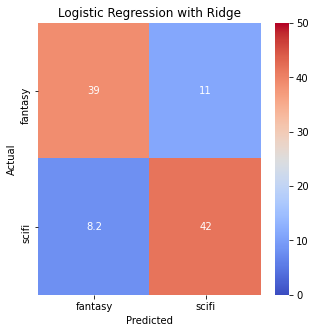

In [45]:
subreddits = ['fantasy', 'scifi']
fig = plt.figure(figsize=(5,5));
ax = fig.add_subplot(111);
preds_ridge = lr_ridge.predict(Xvec_test)
cm = confusion_matrix(y_test, preds_ridge)
cm = cm*100/sum(sum(cm));
sns.heatmap(cm,ax=ax,annot=True, vmin = 0, vmax = 50, cmap='coolwarm');
ax.set_xticklabels(subreddits);
ax.set_yticklabels(subreddits);
plt.xlabel('Predicted');
plt.ylabel('Actual');
plt.title('Logistic Regression with Ridge');




In [47]:
lr_ridge.scores_

{'scifi': array([[0.80564487, 0.81279028, 0.80064309],
        [0.79063951, 0.79242587, 0.78528046],
        [0.79699786, 0.80164403, 0.79985704],
        [0.79842745, 0.80557541, 0.79485347],
        [0.80235883, 0.80664761, 0.79664046]])}

I'll try LASSO again, with a higher C (less regularization) to see if I can reduce the variance without introducing quite as much bias:

In [48]:
lr_lasso10 = LogisticRegressionCV(penalty= 'l1', solver= 'saga', Cs=[10], max_iter=1000,verbose=2)
lr_lasso10.fit(Xvec_train,y_train)
lasso10_train = lr_lasso10.score(Xvec_train,y_train)
lasso10_test = lr_lasso10.score(Xvec_test,y_test)
print(f'Train: {lasso10_train}, Test: {lasso10_test}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 737 seconds


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.3min remaining:    0.0s


max_iter reached after 718 seconds


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 703 seconds


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 729 seconds


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 674 seconds


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 59.4min finished


max_iter reached after 779 seconds
Train: 0.9778444825614637, Test: 0.7965265866209262


/Users/christina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Again, somehow that's actually more overfit than the original log reg model.

In [73]:
# Add these three new models to the scores dataframe:
scores2 = [
    {
    'model': 'LR with Lasso, a=1',
    'train': lasso_train,
    'test' : lasso_test
    },

    {
    'model': 'LR with Lasso, a=10', # note I realize this should say a=1/10, but I don't want to rerun everything
    'train': lasso10_train,
    'test' : lasso10_test
    },

    {
    'model': 'LR with Ridge a=1 (ran 0.1, 1, 10)',
    'train': ridge_train,
    'test' : ridge_test
    }
]
scores2_new = pd.DataFrame(scores2)

scores2_new


,model,train,test
0,"LR with Lasso, a=1",0.892867,0.789237
1,"LR with Lasso, a=10",0.977844,0.796527
2,"LR with Ridge a=1 (ran 0.1, 1, 10)",0.951472,0.806389


In [72]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.append.html
scores_df = scores.append(scores2_new)
scores_df['ndx'] = range(7)
scores_df.set_index('ndx',inplace=True)
scores_df

,train,test
ndx,,
0,0.501809,0.501909
1,0.829448,0.779184
2,0.940715,0.814949
3,0.894628,0.801085
4,0.892867,0.789237
5,0.977844,0.796527
6,0.951472,0.806389


In [68]:


scores_df.to_csv('./data/scores.csv')

### Other notebooks:

* project3_4: KNN models.
  
* project3_5: Tfid instead of CountVectorizer, and experiments with stemming/lemmatizing.

* project3_6: Random Forest models.

* project3_7: Enough modeling, time to visualize.

